# Online Learning and Optimization Course Project

## Squint vs Hedge

#### Milad Jalali
#### Soheil Arabzadeh

In [3]:
import numpy as np
import pandas as pd
from sklearn import svm, linear_model
import math
import matplotlib.pyplot as plt

# Loading Dataset

Source: [AU99a]

Preprocessing: Instance-wise normalization to mean zero and variance one. Then feature-wise normalization to mean zero and variance one. [SKS03a]

number of classes: 2

number of data rows: 62

number of features: 2,000

In [4]:
import pandas as pd
from pandas import DataFrame
from collections import defaultdict
f = open('colon-cancer')
data = defaultdict(list)
for l in f:
    splitted = l.strip().split()
    
    data["y"].append(int(float(splitted[0])))
    for feature in splitted[1:]:
        f_num, f_val = feature.split(":")
        data["x_"+f_num].append(float(f_val))
df = DataFrame(data=data)

# Expert Class
given that we have N=2000 experts,T=62 ,$t=1...T$ and $l_t(i)$ is the i'th expert loss in time t and $L_t(i)=\sum_{t=1}^{T}l _t(i)$ is the cummulative loss of the i'th expert in time t. in expert problem we define regret as $R_T = \sum_{t=1}^{T}<p_t,l_t>-\sum_{t=1}^{T}l_t(i^*)$ also we can we define instantaneous regret as $r_t(i) = <p_t,l_t> - l_t(i)$ and cumulative regret as $R_t(i) =\sum_{t=1}^{T}r_t(i)$. in this problem we define $l_t(i) = \frac{(1-\hat{y_t(i)}y_t)^2}{4}$ where $\hat{y_t(i)}$ is the i'th expert predection of whether the person t has cancer or not and $y_t$ is the t'th person label.we learn $\hat{y_t(i)}$ using regularized linear models with stochastic gradient descent (SGD) learning(the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule [aka learning rate]. SGD allows minibatch [online/out-of-core] learning)

In [5]:
class Expert:
    def get_advice(self,x):
        return self.clf.predict(x)[0]

    def update_expert(self,x,y):
        self.clf.fit(x,y)
    
    def expert_loss(self, x, y):
        y_hat = self.get_advice(x)
        return ((1- y_hat*y)**2 / 4.0)
    
    def __init__(self):
        self.clf = linear_model.SGDClassifier()
    

In [6]:
class OnlineExpert:
    def get_advice(self,x):
        return self.clf.predict(x)[0]

    def update_expert(self,x,y):
        self.clf.partial_fit(x,y,np.array([-1,1]))
    
    def expert_loss(self, x, y):
        y_hat = self.get_advice(x)
        return ((1- y_hat*y)**2 / 4.0)
    
    def __init__(self):
        self.clf = linear_model.SGDClassifier(warm_start=True)
    

# Hedge
in this algorithm we pick $p_t(i) \propto  exp(-\eta L_{t-1}(i))$ or $p_t(i) \propto  exp(\eta R_{t-1}(i))$.
we can prove that if we set $\eta = \frac{\sqrt{ln(N)}}{T}$ then $R_T \leq \sqrt{Tln(N)}$

In [7]:
class HedgeLearner:
    def __init__(self, num_experts, observations, experts):
        self.weights = np.array([1.0/num_experts] * num_experts)
        self.experts = experts
        self.num_experts = num_experts
        self.observations = observations
        self.eta = math.sqrt(math.log(num_experts)/observations.shape[0])


    def learn(self, total_prediction_rounds):
        total_learner_loss = 0
        learner_loss_plt = []
        experts_loss_plt = []
        
        for round_number in range(total_prediction_rounds):
            print("round number: ", round_number )
            observation = self.observations.loc[[round_number]]
            y = observation.loc[:, ["y"]].values.ravel()
            if round_number == 0:
                for i, ex in enumerate(self.experts):
                    x = observation.loc[:, ["x_"+str(i+1)]].values
                    ex.update_expert(x, y)
            else:
                prediction = self.randomized_weighted_majority(observation)
                learner_loss = self.loss(prediction, y)
                expert_losses = []
                for i, ex in enumerate(self.experts):
                    x = observation.loc[:, ["x_"+str(i+1)]].values
                    expert_losses.append(ex.expert_loss(x, y))
                    ex.update_expert(x, y)
                total_learner_loss += learner_loss
                self.update_weights(np.array(expert_losses))
                print("Prediction: {}, Label: {}, Learner Loss: {}".format(prediction, y, learner_loss))
                learner_loss_plt.append(learner_loss)
                experts_loss_plt.append(expert_losses)
            
            
        return total_learner_loss, learner_loss_plt, experts_loss_plt

    
    def randomized_weighted_majority(self, observation):
        sum_weights = np.sum(self.weights)
        idx = np.argmax(np.random.multinomial(1, np.divide(self.weights, sum_weights)))
        x = observation.loc[:, ["x_"+str(idx+1)]].values
        prediction = self.experts[idx].get_advice(x)
        return prediction
        
    def loss(self, y_hat,y):
        return ((1- y_hat*y)**2 / 4.0)
    
    def update_weights(self,expert_losses):
        update_factor = np.exp(-self.eta * expert_losses).ravel()
        new_weights = update_factor * self.weights
        self.weights = new_weights


In [8]:
num_experts = 2000
online_experts = []
for i in range(num_experts):    
    ex = OnlineExpert()    
    online_experts.append(ex)
hedge = HedgeLearner(num_experts, df, online_experts)

In [9]:
hedge_total_learner_loss, hedge_learner_loss, hedge_experts_loss = hedge.learn(62)

round number:  0
round number:  1
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  2
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  3
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  4
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  5
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  6
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  7
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  8
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  9
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  10
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  11
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  12
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  13
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  14
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  15
Prediction: -1, Label: [1], Learner Loss: [ 1.]
ro

In [10]:
def calculate_cumulative_loss(total_prediction_rounds, learner_loss, experts_loss):
    experts_loss = np.asarray(experts_loss)
    #print experts_loss
    cumulative_learner_loss = []
    cumulative_experts_loss = []
    cl_experts = [0]*len(experts_loss[0])
    for i in range(total_prediction_rounds):
        cumulative_learner_loss.append(sum(learner_loss[0:i+1]))
        for k in range(len(experts_loss[0])):
            cl_experts[k] = sum(experts_loss[0:i+1,k])
        cumulative_experts_loss.append(list(cl_experts))
    return cumulative_learner_loss, cumulative_experts_loss

def plot_cumulative_losses(total_prediction_rounds, learner_loss, experts_loss, k_top_experts):
    experts_loss = np.asarray(experts_loss)
    top_experts = np.argsort(experts_loss[-1,:,0])[:k_top_experts]
    t = np.linspace(0, total_prediction_rounds-1, total_prediction_rounds)
    plt.figure()
    plt.plot(t, learner_loss, 'k', label="Cumulative loss of learner")
    for i in top_experts:
        plt.plot(t, experts_loss[:, [i]].ravel(), label = "Cumulative loss of expert {}".format(i+1))
    plt.legend()
    plt.draw()


In [14]:
def calculate_average_regret(total_prediction_rounds, learner_loss, experts_loss):
    experts_loss = np.asarray(experts_loss)
    cumulative_learner_loss = []
    cumulative_experts_loss = []
    cl_experts = [0]*len(experts_loss[0])
    for i in range(total_prediction_rounds):
        cumulative_learner_loss.append(sum(learner_loss[0:i+1]))
        for k in range(len(experts_loss[0])):
            cl_experts[k] = sum(experts_loss[0:i+1,k])
        cumulative_experts_loss.append(list(cl_experts))
    episode_regrets = []

    for i in range(total_prediction_rounds):
        best_expert_loss = min(cumulative_experts_loss[i])
        episode_regrets.append((cumulative_learner_loss[i] - best_expert_loss)/(i+1.))
    return episode_regrets

def plot_episode_regrets(total_prediction_rounds, episode_regrets):
    t = np.linspace(0, total_prediction_rounds-1, total_prediction_rounds)
    plt.figure()
    plt.plot(t, episode_regrets, 'k', label = "Average Regret")
    plt.xlabel("Prediction Rounds")
    plt.ylabel("Average Regret")
    plt.draw()

In [16]:
def generate_reports(total_prediction_rounds, total_learner_loss, learner_loss, experts_loss, top_experts = 10):
    cll, cel = calculate_cumulative_loss(total_prediction_rounds, learner_loss, experts_loss)
    plot_cumulative_losses(total_prediction_rounds, cll, cel,top_experts)
    regrets = calculate_average_regret(total_prediction_rounds, learner_loss, experts_loss)
    plot_episode_regrets(total_prediction_rounds, regrets)

# Squint
in this algorithm we pick $p_t(i) \propto  exp(\eta R_{t-1}(i)-\eta^2 V_{t-1}(i))$. where $V_t(i) = \sum_{t=1}^{T}r_t(i)^2$
we can prove that if we intitialy pick p according to distribution q and chose $\eta$ in a good manner then we have the following regret bound:$$E_{i\sim q}[R_t]\leq 2\sqrt{E_{i\sim q}[V_t(i)]KL(q,p_1)}$$
details of implementation is in the following link http://blog.wouterkoolen.info/Squint_implementation/post.html.
as you can see our bound depends on the sum of squre losses so this algorithm is very good when we have small losses.
so if we compare this two algorithms squint will work better if we have small losses

In [17]:
class SquintLearner:
    def __init__(self, num_experts, observations, experts):
        self.weights = np.array([1.0/num_experts] * num_experts)
        self.experts = experts
        self.num_experts = num_experts
        self.observations = observations
        self.eta = 0.45


    def learn(self, total_prediction_rounds):
        total_learner_loss = 0
        learner_loss_plt = []
        experts_loss_plt = []
        
        for round_number in range(total_prediction_rounds):
            print("round number: ", round_number )
            observation = self.observations.loc[[round_number]]
            y = observation.loc[:, ["y"]].values.ravel()
            if round_number == 0:
                for i, ex in enumerate(self.experts):
                    x = observation.loc[:, ["x_"+str(i+1)]].values
                    ex.update_expert(x, y)
            else:
                prediction = self.randomized_weighted_majority(observation)
                learner_loss = self.loss(prediction, y)
                expert_losses = []
                for i, ex in enumerate(self.experts):
                    x = observation.loc[:, ["x_"+str(i+1)]].values
                    expert_losses.append(ex.expert_loss(x, y))
                    ex.update_expert(x, y)
                total_learner_loss += learner_loss
                self.update_weights(np.array(expert_losses))
                print("Prediction: {}, Label: {}, Learner Loss: {}".format(prediction, y, learner_loss))
                learner_loss_plt.append(learner_loss)
                experts_loss_plt.append(expert_losses)
            
            
        return total_learner_loss, learner_loss_plt, experts_loss_plt

    
    def randomized_weighted_majority(self, observation):
        sum_weights = np.sum(self.weights)
        idx = np.argmax(np.random.multinomial(1, np.divide(self.weights, sum_weights)))
        x = observation.loc[:, ["x_"+str(idx+1)]].values
        prediction = self.experts[idx].get_advice(x)
        return prediction
    
        
    def loss(self, y_hat,y):
        return ((1- y_hat*y)**2 / 4.0)
    
    def update_weights(self,expert_losses):
        expected_loss = np.dot(np.divide(self.weights, np.sum(self.weights)), expert_losses)
        regrets = np.array([expected_loss] * len(expert_losses)) - expert_losses 
        first_order_factor = np.exp(self.eta * regrets).ravel()
        second_order_factor = np.exp(-self.eta**2 * np.power(regrets, 2)).ravel()
        new_weights = first_order_factor * self.weights
        new_weights = second_order_factor * self.weights
        self.weights = new_weights


In [18]:
num_experts = 2000
online_experts = []
for i in range(num_experts):    
    ex = OnlineExpert()    
    online_experts.append(ex)
squint = SquintLearner(num_experts, df, online_experts)

In [19]:
squint_total_learner_loss, squint_learner_loss, squint_experts_loss = squint.learn(62)

round number:  0
round number:  1
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  2
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  3
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  4
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  5
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  6
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  7
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  8
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  9
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  10
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  11
Prediction: 1, Label: [1], Learner Loss: [ 0.]
round number:  12
Prediction: -1, Label: [-1], Learner Loss: [ 0.]
round number:  13
Prediction: -1, Label: [1], Learner Loss: [ 1.]
round number:  14
Prediction: 1, Label: [-1], Learner Loss: [ 1.]
round number:  15
Prediction: -1, Label: [1], Learner Loss: [ 1.]
rou

# Comparison

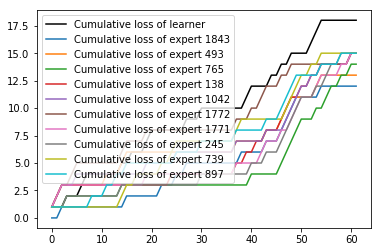

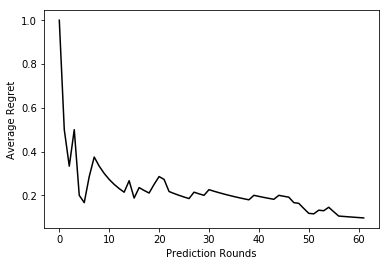

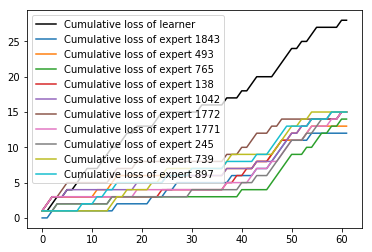

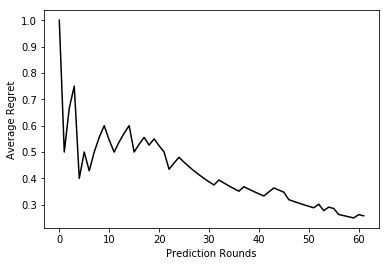

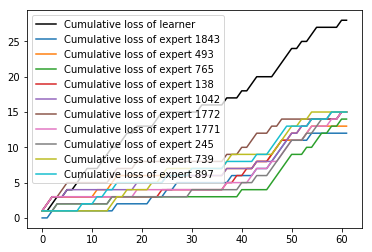

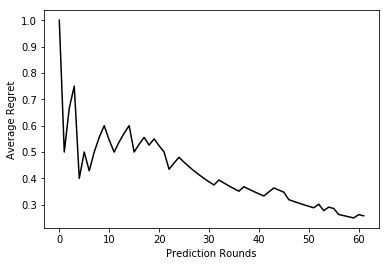

In [21]:
generate_reports(62, squint_total_learner_loss, squint_learner_loss, squint_experts_loss)
plt.show()

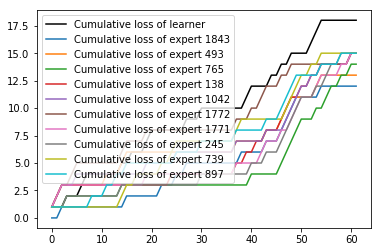

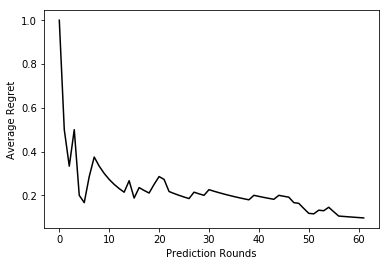

In [22]:
generate_reports(62, hedge_total_learner_loss, hedge_learner_loss, hedge_experts_loss)
plt.show()

In [79]:
print(squint_total_learner_loss, hedge_total_learner_loss)

[32.] [25.]


# Conclusion
as you can see squint does not outperform hedge algorithm and this shows us that our losses are not small.